In [1]:
from __future__ import division, print_function

%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [32]:
import os
import ketu
import h5py
import fitsio
import transit
import triangle
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from subprocess import check_call
from scipy.stats import gaussian_kde 
from collections import namedtuple

In [3]:
candidates = np.array(open("candidates.txt", "r").readlines(), dtype=int)

In [4]:
candidates

array([201208431, 201257461, 201295312, 201338508, 201367065, 201384232,
       201393098, 201403446, 201445392, 201465501, 201505350, 201546283,
       201549860, 201555883, 201565013, 201569483, 201577035, 201596316,
       201613023, 201617985, 201629650, 201635569, 201649426, 201702477,
       201736247, 201754305, 201779067, 201828749, 201855371, 201912552,
       201929294])

In [5]:
def calc_hist(x, w, fmt):
    q = triangle.quantile(x, [0.16, 0.5, 0.84], weights=w)
    mu = np.sum(x * w) / np.sum(w)
    std = np.sqrt(np.sum((x - mu)**2 * w) / np.sum(w))
    v = "{{0:{0}}} \pm {{{{{{1:{0}}}}}}}".format(fmt).format(mu, std)
#     d = np.diff(q)
#     v = ("{{0:{0}}}_{{{{-{{1:{0}}}}}}}^{{{{+{{2:{0}}}}}}}"
#          .format(fmt).format(q[1], d[0], d[1]))
    return q, v

def plot_hist(x, w, nm, units, fmt=".2f"):
    q, v = calc_hist(x, w, fmt)
    d = np.diff(q)
    bins = np.linspace(q[1] - 3 * d[0], q[1] + 3 * d[1], 12)
    
    fig, ax = pl.subplots()
    ax.hist(x, bins, weights=w, color="k", histtype="step", normed=True)
    ax.axvline(q[1], color="k")
    ax.axvline(q[0], color="k", linestyle="dashed")
    ax.axvline(q[2], color="k", linestyle="dashed")
    if units is None:
        ax.set_xlabel("${0}$".format(nm))
    else:
        ax.set_xlabel("${0}\,[{1}]$".format(nm, units))
    ax.set_yticklabels([])
    if units is not None:
        v = "$" + nm + " = " + v + " \, {0}$".format(units)
    else:
        v = "$" + nm + " = " + v + "$"
    ax.set_title(v)

In [6]:
d = "starmodels_inflated"

def process_row(epic):
    if epic == 201912552:
        mu = np.array([0.394, 0.413])
        cov = np.diag([0.038, 0.043])**2
        te = 3503 + 60 * np.random.randn(1e5)
    else:    
        fn = "stlr/{1}/{0}.h5".format(int(epic), d)
        if not os.path.exists(fn):
            try:
                os.makedirs("stlr/" + d)
            except os.error:
                pass
            check_call("wget -O {0} http://www.astro.princeton.edu/~tdm/k2/{2}/{1}.h5"
                       .format(fn, int(epic), d), shell=True)

        # Load the stellar samples and build the Gaussian model.
        star = pd.read_hdf(fn, "samples")
        X = np.array(star[["radius", "mass"]])
        mu = np.mean(X, axis=0)
        cov = np.cov(X, rowvar=0)
        print(mu, np.sqrt(np.diag(cov)))

        te = np.array(star.Teff)
    
    # KDE shite.
    # kde = gaussian_kde(np.array(star[["radius", "mass"]]).T)
    # Plot the KDE model.
    #     x = np.linspace(star.radius.min(), star.radius.max(), 75)
    #     y = np.linspace(star.mass.min(), star.mass.max(), 77)
    #     X, Y = np.meshgrid(x, y, indexing="ij")
    #     positions = np.vstack([X.ravel(), Y.ravel()]) 
    #     Z = kde(positions).reshape((len(x), len(y)))
    #     pl.pcolor(X, Y, Z, cmap="gray_r")
    #     pl.plot(star.radius, star.mass, ".r", alpha=0.01)

    # Load the samples and convert them to a DataFrame.
    fn = "../ketu/char_old/{0}/chain.h5".format(int(epic))
    with h5py.File(fn, "r") as f:
        s0 = f["chain"][::5, :, :]
    cols = ["ln_R_star", "ln_M_star", "q_1", "q_2"]
    i = 1
    while len(cols) < s0.shape[-1]:
        cols += [k + "_{0}".format(i) for k in
                 ("ln_R_p", "ln_P", "t_0", "b", "sqrt_e_sin_omega", "sqrt_e_cos_omega")]
        i += 1
    nplanets = i - 1
    dtype = [(k, np.float64) for k in cols]
    samples = pd.DataFrame.from_items(zip(cols, s0.reshape((-1, s0.shape[-1])).T))
    
    # Supplement the samples with Teff measurements drawn from the stellar properties.
    inds = np.random.randint(len(te), size=len(samples))
    samples["teff"] = te[inds]
    
    r = (np.exp(np.array(samples[["ln_R_star", "ln_M_star"]])) - mu).T
    lnw = -0.5 * np.sum(np.linalg.solve(cov, r) * r, axis=0)
    
    # lnw = np.log(kde(np.exp(np.array(samples[["ln_R_star", "ln_M_star"]])).T))
    
    # Dartmouth model.
    #     # Compute probability under the measured stellar parameters.
    #     lnw = ((np.exp(samples.ln_R_star) - row.Rad) / row.e_Rad) ** 2
    #     lnw += ((np.exp(samples.ln_M_star) - row.M) / row.e_M) ** 2
    #     lnw *= -0.5
    
    # Inculde the interim prior that was 1/R and 1/M.
    lnw += samples.ln_R_star + samples.ln_M_star
    
    # Use this to compute the weights for the samples.
    samples["weights"] = np.exp(lnw + lnw.max())
    
    rows = []
    for i in range(nplanets):
        r = ["{0}".format(int(epic)), "{0}".format(i+1)]
        w = np.array(samples.weights)

        # Plot the period measurement.
        x = np.exp(np.array(samples["ln_P_{0}".format(i+1)]))
        _, v = calc_hist(x, w, ".4f")
        r.append(v)
        # plot_hist(x, w, "P_{{{0}}}".format(i+1), "\mathrm{days}", fmt=".5f")

        # Plot the radius measurement.
        x = np.exp(np.array(samples["ln_R_p_{0}".format(i+1)])) / 0.009155
        _, v = calc_hist(x, w, ".2f")
        r.append(v)
        # plot_hist(x, w, "R_{{p,{0}}}".format(i+1), "R_\oplus", fmt=".2f")
        
        # Plot the a/R_* measurement.
        # Newton's constant in $R_\odot^3 M_\odot^{-1} {days}^{-2}$.
        _G = 2945.4625385377644
        lnp = samples["ln_P_{0}".format(i+1)]
        lnms = samples.ln_M_star
        a = np.array(_G * np.exp(2*lnp+lnms)/(4*np.pi*np.pi)) ** (1./3)
        
        _, v = calc_hist(a * np.exp(-samples.ln_R_star), w, ".2f")
        r.append(v)
        
        _, v = calc_hist(a / 215.1, w, ".4f")
        r.append(v)
        # plot_hist(a / 215.1, w, "{{a}}_{{{0}}}".format(i+1), "\mathrm{AU}", fmt=".4f")
        
        # Teq
        teq = samples.teff / np.sqrt(2. * a * np.exp(-samples.ln_R_star))
        _, v = calc_hist(teq, w, ".0f")
        r.append(v)
        # plot_hist(teq, w, "{{T_\mathrm{{eq}}}}_{{{0}}}".format(i+1), "\mathrm{K}", fmt=".0f")
        
        rows.append(" & ".join(r) + " \\")
    return rows

In [53]:
NSAMPLES = 50

def process_row_2(epic):
    # Load the samples and convert them to a DataFrame.
    fn = "../ketu/char/{0}/chain.h5".format(int(epic))
    if not os.path.exists(fn):
        print(epic, "failed")
        return
    with h5py.File(fn, "r") as f:
        s0 = f["chain"][-100000:, :, :]
        lnprob = f["lnprob"][...]
    i, j = -1, 10  # np.unravel_index(np.argmax(lnprob), lnprob.shape)
    best_sample = s0[i, j, :]
    cols = ["ln_R_star", "ln_M_star", "ln_Teff", "q_1", "q_2"]
    i = 1
    while len(cols) < s0.shape[-1]:
        cols += [k + "_{0}".format(i) for k in
                 ("ln_R_p", "ln_P", "t_0", "b", "sqrt_e_sin_omega", "sqrt_e_cos_omega")]
        i += 1
    nplanets = i - 1
    dtype = [(k, np.float64) for k in cols]
    flatsamples = s0.reshape((-1, s0.shape[-1]))
    samples = pd.DataFrame.from_items(zip(cols, flatsamples.T))
    best_sample = dict(zip(cols, best_sample))
        
    rows = []
    for i in range(nplanets):
        r = ["{0}.{1:02d}".format(int(epic), i+1)]
        w = np.ones(len(samples))
        
        # Plot the period measurement.
        x = np.exp(np.array(samples["ln_P_{0}".format(i+1)]))
        _, v = calc_hist(x, w, ".5f")
        r.append(v)
        # plot_hist(x, w, "P_{{{0}}}".format(i+1), "\mathrm{days}", fmt=".5f")
        
        # Epoch measurement.
        x = np.array(samples["t_0_{0}".format(i+1)])
        _, v = calc_hist(x, w, ".4f")
        r.append(v)

        # Plot the radius measurement.
        x = np.exp(np.array(samples["ln_R_p_{0}".format(i+1)])) / 0.009155
        _, v = calc_hist(x, w, ".2f")
        r.append(v)
        # plot_hist(x, w, "R_{{p,{0}}}".format(i+1), "R_\oplus", fmt=".2f")
        
        # Plot the a/R_* measurement.
        # Newton's constant in $R_\odot^3 M_\odot^{-1} {days}^{-2}$.
        _G = 2945.4625385377644
        lnp = samples["ln_P_{0}".format(i+1)]
        lnms = samples.ln_M_star
        a = np.array(_G * np.exp(2*lnp+lnms)/(4*np.pi*np.pi)) ** (1./3)
        
        _, v = calc_hist(a * np.exp(-samples.ln_R_star), w, ".2f")
        r.append(v)
        
        _, v = calc_hist(a / 215.1, w, ".4f")
        r.append(v)
        # plot_hist(a / 215.1, w, "{{a}}_{{{0}}}".format(i+1), "\mathrm{AU}", fmt=".4f")
        
        # Teq
        teq = np.exp(samples.ln_Teff) / np.sqrt(2. * a * np.exp(-samples.ln_R_star))
        _, v = calc_hist(teq, w, ".0f")
        r.append(v)
        # plot_hist(teq, w, "{{T_\mathrm{{eq}}}}_{{{0}}}".format(i+1), "\mathrm{K}", fmt=".0f")
        
        rows.append(" & ".join(r) + " \\")

        # Save the de-trended light curve and model.
        pipe = ketu.k2.Data(cache=False)
        pipe = ketu.k2.Likelihood(pipe, cache=False)
        datadir = "/export/bbq2/dfm/k2/web"
        epicid = str(epic)
        q = dict(
            light_curve_file=os.path.join(datadir,
                                          "lightcurves/c1/{0}00000/{1}000/ktwo{2}-c01_lpd-lc.fits"
                                          .format(epicid[:4], epicid[4:6], epicid)),
            basis_file="/export/bbq2/dfm/k2/web/elcs/c1.h5",
            catalog_file=os.path.join(datadir, "catalogs/epic.h5"),
            nbasis=150,
            initial_time=1975.,
        )
        r = pipe.query(**q)
        lc = r.model_light_curves[0]
        
        # Build the sample results files.
        t = np.linspace(-4, 4, 5000)
        y = np.empty((NSAMPLES, len(t)))
        corr_flux = np.empty((NSAMPLES, len(lc.time)))

        for k in range(NSAMPLES):
            ind = np.random.randint(len(samples))
            samp = samples.iloc[k]
            period = np.exp(samp["ln_P_{0}".format(i+1)])
            t0 = samp["t_0_{0}".format(i+1)]
            rp = np.exp(samp["ln_R_p_{0}".format(i+1)])
            b = samp["b_{0}".format(i+1)]
            sesn = samp["sqrt_e_sin_omega_{0}".format(i+1)]
            secs = samp["sqrt_e_cos_omega_{0}".format(i+1)]
            e = sesn**2 + secs**2
            pomega = np.arctan2(sesn, secs)

            star = transit.Central(radius=np.exp(samp["ln_R_star"]),
                                   mass=np.exp(samp["ln_M_star"]),
                                   q1=samp["q_1"],
                                   q2=samp["q_2"])
            system = transit.System(star)
            system.add_body(transit.Body(r=rp, period=period, t0=t0, b=b, e=e, pomega=pomega))

            # Compute prediction.
            y[k] = (system.light_curve(t + t0, texp=lc.texp) - 1.0) * 1e3

            # Add the other planets in.
            for j in range(nplanets):
                if i == j:
                    continue
                period2 = np.exp(samp["ln_P_{0}".format(j+1)])
                t02 = samp["t_0_{0}".format(j+1)]
                rp = np.exp(samp["ln_R_p_{0}".format(j+1)])
                b = samp["b_{0}".format(j+1)]
                sesn = samp["sqrt_e_sin_omega_{0}".format(j+1)]
                secs = samp["sqrt_e_cos_omega_{0}".format(j+1)]
                e = sesn**2 + secs**2
                pomega = np.arctan2(sesn, secs)

                system.add_body(transit.Body(r=rp, period=period2, t0=t02, b=b, e=e, pomega=pomega))

            # Remove the prediction.
            resid = lc.flux - (system.light_curve(lc.time, texp=lc.texp) - 1.0) * 1e3
            corr_flux[k] = lc.flux - lc.predict(resid)
        
        corr_flux = np.median(corr_flux, axis=0)
        
        d = "corr/{0}".format(epic)
        fn = os.path.join(d, "{0}.h5".format(i+1))
        try:
            os.makedirs(d)
        except os.error:
            pass
        corr = np.array(zip(lc.time, corr_flux), dtype=[("time", float), ("corr_flux", float)])
        pred = np.array(map(tuple, np.vstack((t, np.median(y, axis=0))).T),
                        dtype=[("time_since_transit", float), ("model_flux", float)])
        with h5py.File(fn, "w") as f:
            f.attrs["period"] = period
            f.attrs["t0"] = t0
            f.create_dataset("corr_data", data=corr)
            f.create_dataset("model", data=pred)
        
        pl.clf()
        tt = (lc.time - t0 + 0.5*period) % period - 0.5 * period
        pl.plot(tt, corr_flux, ".k")
        pl.plot(t, np.median(y, axis=0), "g")
        pl.xlim(-2, 2)
        pl.savefig(os.path.join(d, "{0}.png".format(i+1)))
    return rows

Querying Data
Finished querying Data in 0.30s
Querying Likelihood
3580 3591
3579 3580
3579 3579
Finished querying Likelihood in 0.09s
$201257461.01$ & $50.26759 \pm {0.00743}$ & $20.3803 \pm {0.0185}$ & $13.55 \pm {8.55}$ & $79.73 \pm {4.60}$ & $0.2323 \pm {0.0066}$ & $381 \pm {13} $ \\


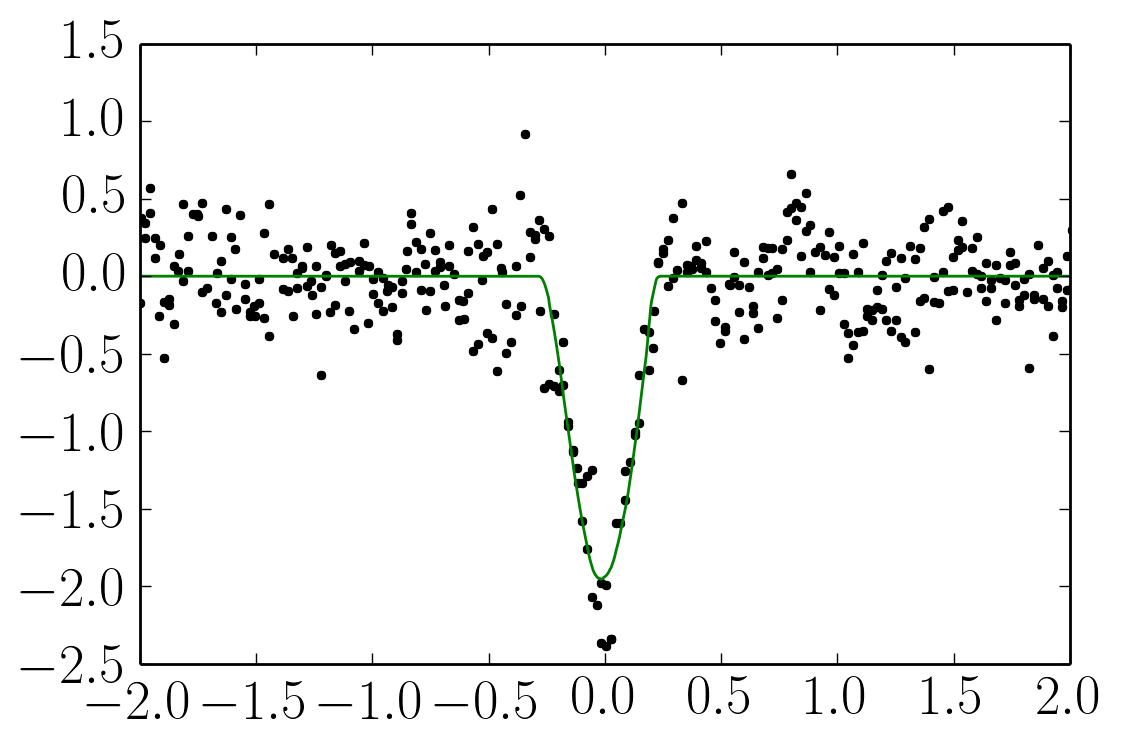

In [54]:
r = process_row_2(201257461)[0]
print("$" + r.replace(" & ", "$ & $")[:-1] + r"$ \\")

Querying Data
Finished querying Data in 0.38s
Querying Likelihood
3652 3672
3651 3652
3651 3651
Finished querying Likelihood in 0.09s
Querying Data
Finished querying Data in 0.27s
Querying Likelihood
3580 3591
3579 3580
3579 3579
Finished querying Likelihood in 0.09s
Querying Data
Finished querying Data in 0.34s
Querying Likelihood
3592 3606
3593 3592
3592 3593
3591 3592
3591 3591
Finished querying Likelihood in 0.11s
Querying Data
Finished querying Data in 0.31s
Querying Likelihood
3653 3666
3653 3653
Finished querying Likelihood in 0.08s
Querying Data
Finished querying Data in 0.27s
Querying Likelihood
3653 3666
3653 3653
Finished querying Likelihood in 0.08s
Querying Data
Finished querying Data in 0.34s
Querying Likelihood
3577 3632
3567 3577
3565 3567
3565 3565
Finished querying Likelihood in 0.10s
Querying Data
Finished querying Data in 0.27s
Querying Likelihood
3577 3632
3567 3577
3565 3567
3565 3565
Finished querying Likelihood in 0.10s
Querying Data
Finished querying Data in 0.

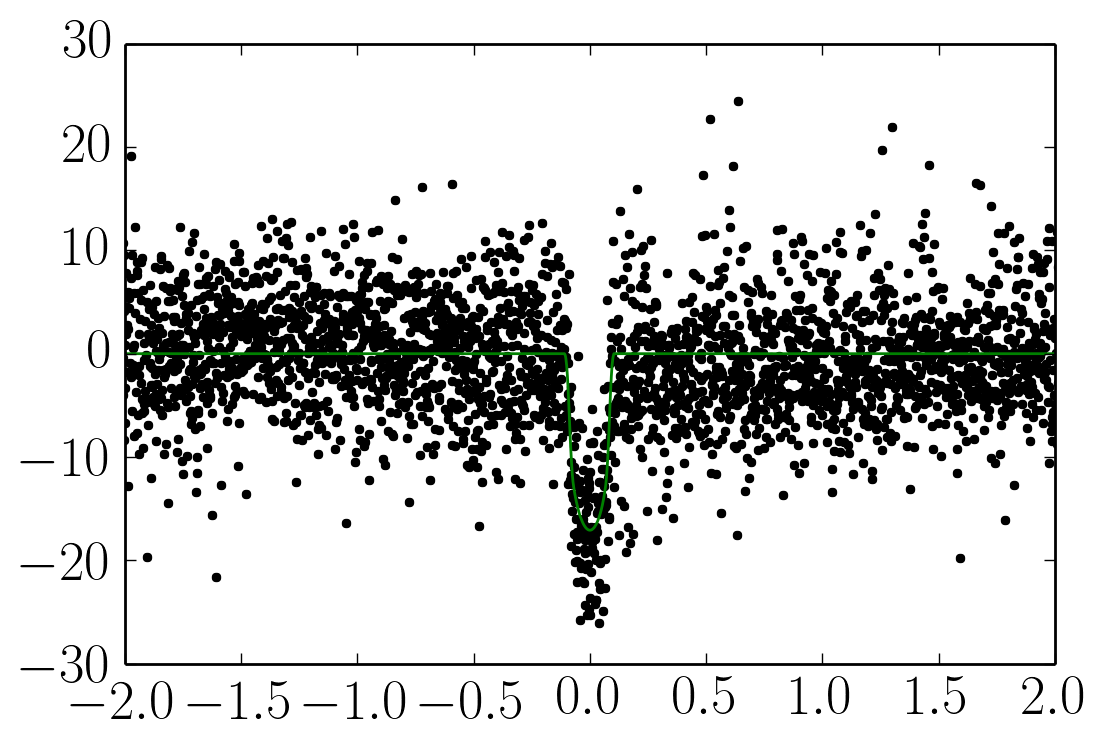

In [55]:
rows = [r for r in (process_row_2(e) for e in candidates) if r is not None]

In [56]:
txt = r"""
\clearpage
%\LongTables
\begin{deluxetable*}{lcccccc}
\tablewidth{0pt}
\tabletypesize{\scriptsize}
\tablecaption{Planet Properties for all Objects of Interest \label{Tab:Planets}}
\tablehead{
\colhead{Candidate} &
\colhead{Period (days)} &
\colhead{Epoch (BJD-2456808)} &
\colhead{Radius ($R_\oplus$)} &
\colhead{$a/R_\star$} &
\colhead{$a$ (AU)} &
\colhead{$T_\mathrm{eq}$ (K)}
}
\startdata
DATADATA
\enddata
\tablecomments{These values and uncertainties are given by the mean and
standard deviation of MCMC posterior samplings.}
\tablenotetext{1}{Parameters inferred from spectroscopic observations.}
\end{deluxetable*}
""".replace("DATADATA", "\\\\ \n".join(["$" + r.replace(" & ", "$ & $")[:-1] + r"$ " for _ in rows for r in _]))

In [57]:
with open("table_planets.tex", "w") as f:
    f.write(txt)

In [58]:
print(txt)


\clearpage
%\LongTables
\begin{deluxetable*}{lcccccc}
\tablewidth{0pt}
\tabletypesize{\scriptsize}
\tablecaption{Planet Properties for all Objects of Interest \label{Tab:Planets}}
\tablehead{
\colhead{Candidate} &
\colhead{Period (days)} &
\colhead{Epoch (BJD-2456808)} &
\colhead{Radius ($R_\oplus$)} &
\colhead{$a/R_\star$} &
\colhead{$a$ (AU)} &
\colhead{$T_\mathrm{eq}$ (K)}
}
\startdata
$201208431.01$ & $10.00411 \pm {0.00163}$ & $7.5198 \pm {0.0085}$ & $2.33 \pm {0.26}$ & $27.68 \pm {0.94}$ & $0.0780 \pm {0.0016}$ & $562 \pm {14} $ \\ 
$201257461.01$ & $50.26759 \pm {0.00743}$ & $20.3803 \pm {0.0185}$ & $13.55 \pm {8.55}$ & $79.73 \pm {4.60}$ & $0.2323 \pm {0.0066}$ & $381 \pm {13} $ \\ 
$201295312.01$ & $5.65621 \pm {0.00075}$ & $3.7229 \pm {0.0114}$ & $1.95 \pm {0.26}$ & $13.43 \pm {1.16}$ & $0.0629 \pm {0.0015}$ & $1150 \pm {55} $ \\ 
$201338508.01$ & $10.93271 \pm {0.00200}$ & $6.5961 \pm {0.0079}$ & $2.14 \pm {0.37}$ & $30.90 \pm {1.66}$ & $0.0804 \pm {0.0024}$ & $526 \pm {21}

In [280]:
def get_aperture(epic):
    datadir = "/export/bbq2/dfm/k2/web"
    epicid = str(epic)
    fn = os.path.join(datadir,
                      "lightcurves/c1/{0}00000/{1}000/ktwo{2}-c01_lpd-lc.fits"
                      .format(epicid[:4], epicid[4:6], epicid))

    aps = fitsio.read(fn, 2)
    var = aps["cdpp6"]
    var[var < 0.0] = np.inf
    i = np.argmin(var)

    return aps[i]["radius"]

In [284]:
pd.DataFrame(dict(epic=candidates, radius=map(get_aperture, candidates))).to_csv("apertures.csv", index=False)